<a href="https://colab.research.google.com/github/djsg2021utec/Recommender_System/blob/main/Pearson_Similarity_Recommender/MovieLens_PS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5> Pearson similarity Recommender</font></h1>

---

<center>
  <img src="https://bobliu.io/assets/img/cards.509a5045.jpg" width="800" height="300">
</center>


## Objetivo de este Notebook

1. Cargar y preprocesar un Dataset.
2. Realizar un sistema de recomendación basado en Pearson Similarity.
3. Comprobar el performance del sistema.

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item31">Contexto</a>  
2. <a href="#item32">Descargar y preparar el Dataset</a>  
6. <a href="#item34">Entrenamiento del modelo</a>  
6. <a href="#item34">Validación del modelo</a>  

</font>
</div>

## 1. Contexto


El conjunto de datos MovieLens es uno de los conjuntos de datos de recomendación más populares y ampliamente utilizados en la investigación de sistemas de recomendación. Fue creado por el GroupLens Research Project en la Universidad de Minnesota para impulsar la investigación en sistemas de recomendación, proporcionando un recurso valioso para la comunidad académica y promoviendo el desarrollo y la comprensión de tecnologías de recomendación personalizada.


<b>Descripción de datos</b>

El conjunto de datos MovieLens contiene información sobre:

<b>Películas:</b> Detalles sobre las películas, incluyendo su título, género y año de lanzamiento.

<b>Usuarios:</b> Perfiles de los usuarios que han calificado y/o etiquetado las películas, incluyendo su ID y otros detalles demográficos opcionales.

<b>Calificaciones:</b> Calificaciones numéricas que los usuarios asignan a las películas en una escala de 1 a 5.

<b>Etiquetas:</b> Palabras clave o tags proporcionados por los usuarios para describir el contenido o la esencia de las películas.

El conjunto de datos es ampliamente utilizado con fines académicos y de investigación, siendo una referencia en el diseño y evaluación de sistemas de recomendación de películas. También es útil para el análisis de tendencias y comportamientos en la visualización de películas y la interacción del usuario con el contenido.

<strong>Puede consultar este [link](https://grouplens.org/datasets/movielens/) para leer más sobre la fuente de datos MovieLens proporcionada por GroupLens Research en la Universidad de Minnesota.</strong>

## 2. Descargar y preparar Dataset

In [1]:
# Descargar el dataset Movielens
!curl -o dataset.zip "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!unzip dataset.zip
!ls -la

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   414k      0  0:00:02  0:00:02 --:--:--  414k
Archive:  dataset.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
total 976
drwxr-xr-x 1 root root   4096 Sep 30 15:05 .
drwxr-xr-x 1 root root   4096 Sep 30 14:46 ..
drwxr-xr-x 4 root root   4096 Sep 28 13:26 .config
-rw-r--r-- 1 root root 978202 Sep 30 15:05 dataset.zip
drwxr-xr-x 2 root root   4096 Sep 26  2018 ml-latest-small
drwxr-xr-x 1 root root   4096 Sep 28 13:26 sample_data


In [2]:
# Principales librerías
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # Turn off warnings


In [3]:
links   = pd.read_csv("ml-latest-small/links.csv")
movies  = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags    = pd.read_csv("ml-latest-small/tags.csv")


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
print("  Movies: {} \n  Ratings: {}".format(len(movies), len(ratings)))


  Movies: 9742 
  Ratings: 100836


In [9]:
# Fusiona ambos datasets basados en la columna 'movieId'
data = pd.merge(ratings, movies, on='movieId')

In [10]:
movie_titles = data['title'].unique().tolist()
movie_ids = data['movieId'].unique().tolist()


In [11]:
# Crear matriz pivotada de usuarios y películas
user_movie_rating = data.pivot_table(index='userId', columns='title', values='rating')


In [14]:
user_movie_rating.shape

(610, 9719)

 Se toman las películas más vistas debido al riesgo de Pearson por falta de datos (Solo 610 apreciaciones)

In [12]:
#500 películas más vistas
movies_pop = user_movie_rating.isnull().sum().sort_values()[:500]


In [15]:
user_movie_rating = user_movie_rating[movies_pop.index.tolist()]

In [16]:
user_movie_rating = user_movie_rating.reset_index()

In [17]:
user_movie_rating.shape

(610, 501)

Muestreo

In [19]:
user_movie_rating

title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
0,1,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
1,2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,...,3.0,NaN,4.5,3.5,NaN,0.5,2.5,NaN,NaN,NaN
606,607,NaN,5.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN
607,608,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,...,NaN,0.5,NaN,NaN,NaN,3.0,2.5,3.0,NaN,4.0
608,609,4.0,4.0,4.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
from sklearn.model_selection import train_test_split

# Convertir la matriz pivotada en un DataFrame y dividir en train y test
train_data, test_data = train_test_split(user_movie_rating, test_size=0.2, random_state=42)


In [22]:
# Volver a crear matrices pivotadas para entrenamiento y prueba
train_data_matrix = train_data.fillna(0)
test_data_matrix = test_data.fillna(0) #Sugeriencia: Técnica de control para los NaN

In [23]:
test_data_matrix.head()

title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
81,82,4.5,0.0,0.0,0.0,4.0,3.5,4.0,4.5,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
218,219,0.0,5.0,4.0,4.5,5.0,5.0,4.0,0.0,4.5,...,0.0,1.5,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0
55,56,5.0,4.0,4.0,5.0,0.0,0.0,5.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,599,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,...,2.5,2.5,0.0,0.0,5.0,2.0,3.5,2.5,0.0,1.5
264,265,0.0,4.0,0.0,5.0,5.0,5.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Pearson Similarity

Aplicaremos el enfoque de similaridad de pearson con enfoque ítem-ítem

In [24]:
# Calcular la matriz de correlación de Pearson entre las películas en el conjunto de entrenamiento
movie_correlation = train_data_matrix.corr() #Es una de las metodologías corr coef es menos escalable si hay mas datas <numpy <spark
#movie_correlation = train_data_matrix.T.corr() #Enfoque user based ¡Cuidado! Los usuarios tienen que tener la misma revisión de películas
movie_correlation = movie_correlation.reset_index()

In [26]:
movie_correlation #Enfoque item-based

title,title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
0,userId,1.000000,0.008199,0.004525,-0.030821,0.009754,0.015238,-0.005643,0.019613,-0.001003,...,0.080874,-0.002378,0.019704,0.009226,0.068704,-0.014580,0.009371,0.011609,-0.005143,0.050271
1,Forrest Gump (1994),0.008199,1.000000,0.396074,0.371809,0.307868,0.235447,0.153545,0.444360,0.406821,...,0.146461,0.176582,0.226408,0.147602,-0.005136,0.092045,0.102592,0.031471,0.114175,0.159355
2,"Shawshank Redemption, The (1994)",0.004525,0.396074,1.000000,0.397146,0.288601,0.182249,0.130601,0.163273,0.339163,...,0.057681,0.070791,0.164133,0.090155,-0.001898,0.022848,0.061298,0.065924,0.029477,0.121649
3,Pulp Fiction (1994),-0.030821,0.371809,0.397146,1.000000,0.477973,0.256708,0.215195,0.332320,0.397953,...,0.116242,0.121564,0.208446,0.193045,0.090673,0.082388,0.110995,0.025801,0.112461,0.093411
4,"Silence of the Lambs, The (1991)",0.009754,0.307868,0.288601,0.477973,1.000000,0.232506,0.243705,0.291041,0.323617,...,0.081297,0.038571,0.174600,0.110835,0.077479,0.131951,0.092813,0.049480,0.172814,0.085438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,Lethal Weapon 3 (1992),-0.014580,0.092045,0.022848,0.082388,0.131951,0.196731,0.183353,0.186405,0.125190,...,0.165244,0.277980,0.049170,0.086496,0.057781,1.000000,0.402797,0.082343,0.068180,0.166401
497,Beverly Hills Cop (1984),0.009371,0.102592,0.061298,0.110995,0.092813,0.223435,0.191155,0.196444,0.151546,...,0.185913,0.231825,0.091777,0.184103,0.077987,0.402797,1.000000,0.127299,0.089872,0.142021
498,Phenomenon (1996),0.011609,0.031471,0.065924,0.025801,0.049480,-0.010880,0.169069,0.016950,0.055102,...,0.118016,0.082636,-0.022420,0.042455,0.256294,0.082343,0.127299,1.000000,0.112858,0.062595
499,M*A*S*H (a.k.a. MASH) (1970),-0.005143,0.114175,0.029477,0.112461,0.172814,0.076116,0.213820,0.149115,0.060981,...,0.178507,0.033955,-0.006431,0.054903,0.062532,0.068180,0.089872,0.112858,1.000000,0.039877


In [25]:
movie_correlation.shape

(501, 502)

In [27]:
# Seleccionar un usuario (por ejemplo, el usuario con ID 5)
user_id = 82

# Películas que el usuario ha visto
user_movies = data[data['userId'] == user_id]
watched_movies = user_movies[['title', 'genres', 'rating']]
watched_movies.sort_values(by = 'rating', ascending = False, inplace = True)

print(f"Películas vistas por el usuario {user_id}:")
watched_movies.head(5) #Se puede poner un treshold (Ejm. >5 para considerar)

Películas vistas por el usuario 82:


,title,genres,rating
45954,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama,4.5
26749,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.5
11310,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy,4.5
65393,Lara Croft: Tomb Raider (2001),Action|Adventure,4.5
66277,Shanghai Knights (2003),Action|Adventure|Comedy,4.5


In [28]:
movie_correlation

title,title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
0,userId,1.000000,0.008199,0.004525,-0.030821,0.009754,0.015238,-0.005643,0.019613,-0.001003,...,0.080874,-0.002378,0.019704,0.009226,0.068704,-0.014580,0.009371,0.011609,-0.005143,0.050271
1,Forrest Gump (1994),0.008199,1.000000,0.396074,0.371809,0.307868,0.235447,0.153545,0.444360,0.406821,...,0.146461,0.176582,0.226408,0.147602,-0.005136,0.092045,0.102592,0.031471,0.114175,0.159355
2,"Shawshank Redemption, The (1994)",0.004525,0.396074,1.000000,0.397146,0.288601,0.182249,0.130601,0.163273,0.339163,...,0.057681,0.070791,0.164133,0.090155,-0.001898,0.022848,0.061298,0.065924,0.029477,0.121649
3,Pulp Fiction (1994),-0.030821,0.371809,0.397146,1.000000,0.477973,0.256708,0.215195,0.332320,0.397953,...,0.116242,0.121564,0.208446,0.193045,0.090673,0.082388,0.110995,0.025801,0.112461,0.093411
4,"Silence of the Lambs, The (1991)",0.009754,0.307868,0.288601,0.477973,1.000000,0.232506,0.243705,0.291041,0.323617,...,0.081297,0.038571,0.174600,0.110835,0.077479,0.131951,0.092813,0.049480,0.172814,0.085438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,Lethal Weapon 3 (1992),-0.014580,0.092045,0.022848,0.082388,0.131951,0.196731,0.183353,0.186405,0.125190,...,0.165244,0.277980,0.049170,0.086496,0.057781,1.000000,0.402797,0.082343,0.068180,0.166401
497,Beverly Hills Cop (1984),0.009371,0.102592,0.061298,0.110995,0.092813,0.223435,0.191155,0.196444,0.151546,...,0.185913,0.231825,0.091777,0.184103,0.077987,0.402797,1.000000,0.127299,0.089872,0.142021
498,Phenomenon (1996),0.011609,0.031471,0.065924,0.025801,0.049480,-0.010880,0.169069,0.016950,0.055102,...,0.118016,0.082636,-0.022420,0.042455,0.256294,0.082343,0.127299,1.000000,0.112858,0.062595
499,M*A*S*H (a.k.a. MASH) (1970),-0.005143,0.114175,0.029477,0.112461,0.172814,0.076116,0.213820,0.149115,0.060981,...,0.178507,0.033955,-0.006431,0.054903,0.062532,0.068180,0.089872,0.112858,1.000000,0.039877


In [29]:
# Porque te gustó "Lethal Weapon 2" .... Se buscan las más correlacionadas
movie_correlation[['title', 'Lethal Weapon 2 (1989)']].sort_values(by = 'Lethal Weapon 2 (1989)', ascending = False)[1:].head(3) #Indicadores de Novelty para las nuevas recomendaciones

title,title,Lethal Weapon 2 (1989)
234,Lethal Weapon (1987),0.582572
496,Lethal Weapon 3 (1992),0.536024
463,Highlander (1986),0.469197


In [30]:
# Porque te gustó "Terminator 2" ....
movie_correlation[['title', 'Terminator 2: Judgment Day (1991)']].sort_values(by = 'Terminator 2: Judgment Day (1991)', ascending = False)[1:].head(3)

title,title,Terminator 2: Judgment Day (1991)
69,"Terminator, The (1984)",0.569060
7,Jurassic Park (1993),0.556805
23,"Fugitive, The (1993)",0.488192


In [31]:
# Porque te gustó "Indiana Jones and the Temple of Doom" ....
movie_correlation[['title', 'Indiana Jones and the Temple of Doom (1984)']].sort_values(by = 'Indiana Jones and the Temple of Doom (1984)', ascending = False)[1:].head(3)

title,title,Indiana Jones and the Temple of Doom (1984)
57,Indiana Jones and the Last Crusade (1989),0.647352
259,RoboCop (1987),0.582504
89,Ghostbusters (a.k.a. Ghost Busters) (1984),0.579382


In [32]:
%%capture
!pip install adjustText

PCA para entender la similaridad

In [33]:
# Crear matriz pivotada de usuarios y películas
user_movie_rating = data.pivot_table(index='userId', columns='title', values='rating')

#30 películas más vistas
movies_pop = user_movie_rating.isnull().sum().sort_values()[:50]

user_movie_rating = user_movie_rating[movies_pop.index.tolist()]
user_movie_rating = user_movie_rating.reset_index()

movie_correlation = user_movie_rating.fillna(0).corr()
movie_correlation = movie_correlation.reset_index()


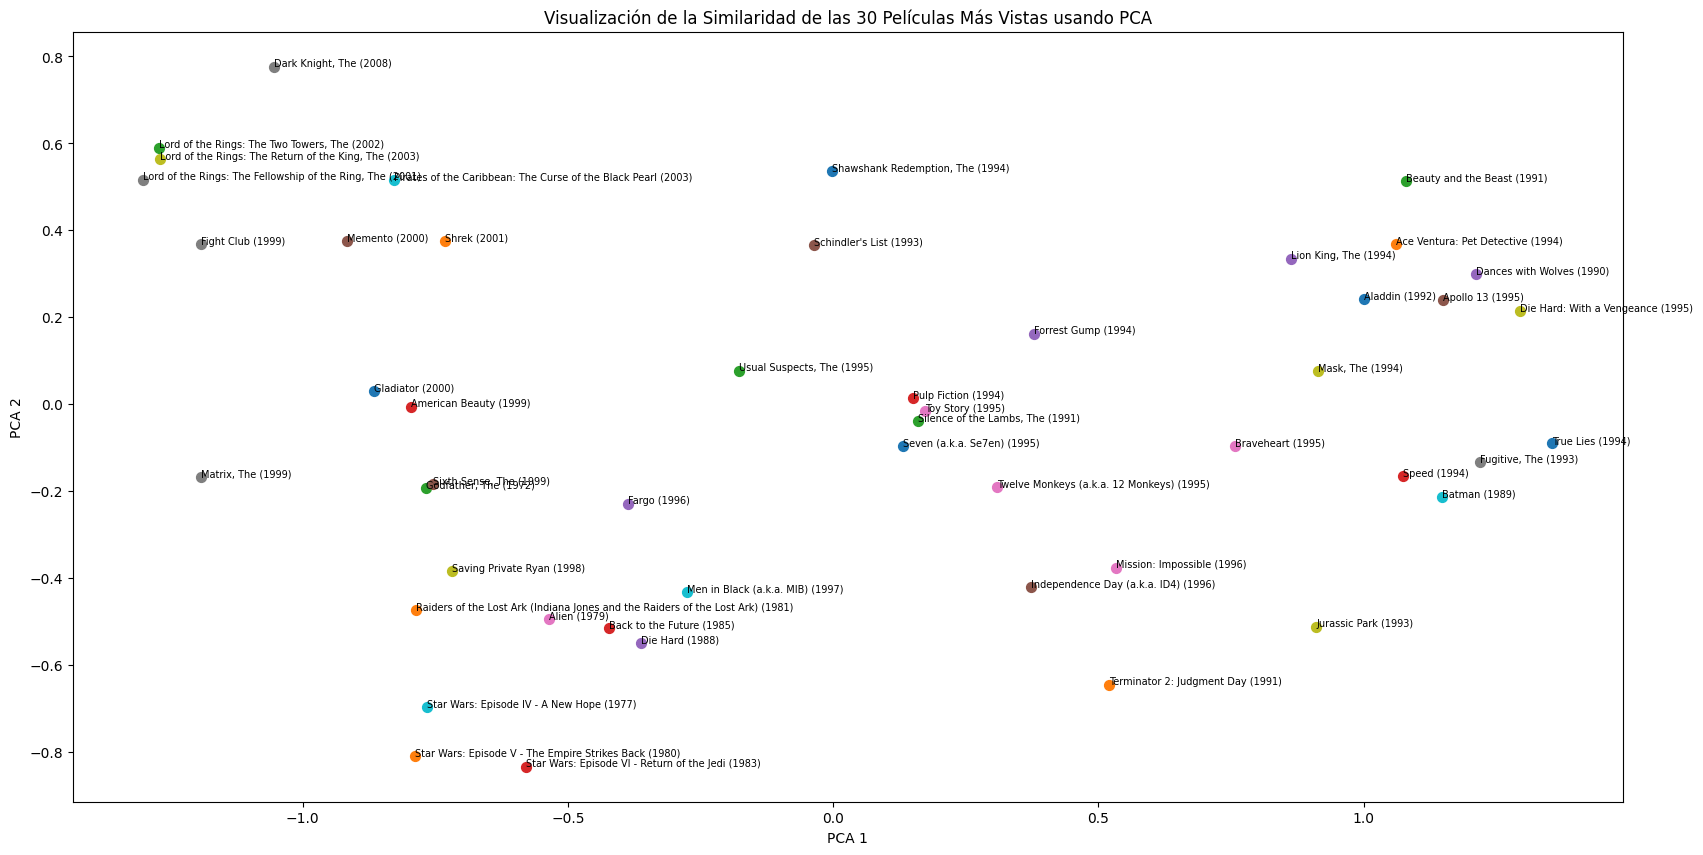

In [34]:
from sklearn.decomposition import PCA
from adjustText import adjust_text

# Aplicar PCA
pca = PCA(n_components=2)
movie_pca = pca.fit_transform(movie_correlation.drop(columns=['title', 'userId']))

# Obtener las n películas más vistas
top_30_movies = user_movie_rating.count().sort_values(ascending=False)[:50].index.tolist()
top_30_movies = list(set(top_30_movies)-set(['title', 'userId']))

# Graficar las n películas más vistas usando PCA
plt.figure(figsize=(20, 10))
for title in top_30_movies:
    idx = movie_correlation[movie_correlation['title'] == title].index[0]
    plt.scatter(movie_pca[idx, 0], movie_pca[idx, 1], s=50)
    plt.text(movie_pca[idx, 0], movie_pca[idx, 1], title, fontsize=7)

# Evitar superposición de etiquetas (si tienes adjustText instalado)
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de la Similaridad de las 30 Películas Más Vistas usando PCA')
plt.show()

## 4. Evaluación del modelo

In [35]:

def recommend_movies(data, user_id, movie_correlation, n_movies=3):
    # 1. Obtener las películas vistas por el usuario y sus calificaciones
    user_ratings = data[data['userId'] == user_id]

    # 2. Ordenar por calificación y tomar las n_movies películas mejor calificadas
    top_user_movies = user_ratings.sort_values(by='rating', ascending=False)['title'].head(n_movies)

    recommended = []
    for movie in top_user_movies:
        # 3. Obtener películas similares basadas en la matriz de correlación
        # Nos aseguramos de que el título de la película exista en la matriz de correlación antes de obtener recomendaciones.
        if movie in movie_correlation.columns:
            similar_movies = movie_correlation[movie].sort_values(ascending=False).index[1:n_movies+1].tolist()
            recommended.extend(similar_movies)

    # 4. Remover duplicados y retornar recomendaciones
    return list(set(recommended))

In [38]:
user_id_sample = 81  # ID de usuario
recommendations = recommend_movies(data, user_id_sample, movie_correlation)
print(recommendations)


[34, 7, 9, 17, 24, 29]


In [39]:
movies[movies.movieId.isin(recommendations)]

,movieId,title,genres
6,7,Sabrina (1995),Comedy|Romance
8,9,Sudden Death (1995),Action
16,17,Sense and Sensibility (1995),Drama|Romance
23,24,Powder (1995),Drama|Sci-Fi
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
32,34,Babe (1995),Children|Drama


Evaluación del hit Rate

In [40]:
def recommend_most_correlated_for_user(user_ratings, movie_correlation):
    recommended_movies = []
    for movie, rating in user_ratings.iteritems():
        if not np.isnan(rating) and movie in movie_correlation.columns:
            most_correlated = movie_correlation[movie].sort_values(ascending=False).index[1]
            recommended_movies.append(most_correlated)
    return recommended_movies

# Aplicar la función a cada fila (usuario) en test_data
test_data['recommended_movies'] = test_data.apply(lambda row: recommend_most_correlated_for_user(row, movie_correlation), axis=1)

In [41]:
def compute_hit_rate(test_data):
    hits = 0
    total_recommendations = 0
    for index, row in test_data.iterrows():
        for recommended_movie in row['recommended_movies']:
            if not np.isnan(row[recommended_movie]):
                hits += 1
            total_recommendations += 1
    hit_rate = hits / total_recommendations if total_recommendations != 0 else 0
    return hit_rate

hit_rate = compute_hit_rate(test_data)
print(f"Hit Rate: {hit_rate:.4f}")

Hit Rate: 0.7279


In [43]:
# Calculando hit rate para test
test_hit_rate = hit_rate(train_data_matrix.values, movie_correlation, test_data_matrix.values)
print(f"Hit Rate (Test): {test_hit_rate:.4f}")

TypeError: ignored

MAE, RMSE

In [44]:
# Predicciones para cada película que el usuario ha calificado
def compute_predictions(row, movie_correlation):
    predictions = {}
    for movie in row.dropna().index:
        if movie != 'recommended_movies':
            predicted_rating = predict_rating(row, movie, movie_correlation)
            if not np.isnan(predicted_rating):
                predictions[movie] = predicted_rating
    return predictions

test_data['predictions'] = test_data.apply(lambda row: compute_predictions(row, movie_correlation), axis=1)

# Calcular los errores para las predicciones
def compute_errors(row):
    errors = {}
    for movie, predicted_rating in row['predictions'].items():
        real_rating = row[movie]
        if not np.isnan(real_rating):
            errors[movie] = real_rating - predicted_rating
    return errors



NameError: ignored

In [45]:
test_data['errors'] = test_data.apply(compute_errors, axis=1)

# Calcular MAE y RMSE
all_errors = [error for movie_errors in test_data['errors'] for error in movie_errors.values()]

mae = np.mean(np.abs(all_errors))
rmse = np.sqrt(np.mean(np.square(all_errors)))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

NameError: ignored

---
## Gracias por completar este laboratorio!